DATA DRIFTING

In [1]:
import sys
!{sys.executable} -m pip install alibi-detect

  Using cached alibi_detect-0.12.0-py3-none-any.whl.metadata (28 kB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.6 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.6 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.6 MB 645.7 kB/s eta 0:00:04
   --------------- ------------------------ 1.0/2.6 MB 1.1 MB/s eta 0:00:02
   ------------------- -------------------- 1.3/2.6 MB 1.2 MB/s eta 0:00:02
   ----------------------- ---------------- 1.6/2.6 MB 1.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 1.2 MB/s eta 0:00:01
   --------------------------- ------------ 1.8/2.6 MB 1.2 MB/s eta 0:00:01
   ----------------------------------- ---- 2.4/2.6 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------  2.6/2.6 MB 1.2 MB/s eta 0:00:01
   ---------------------------------------  2


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.mixture import GaussianMixture
from alibi_detect.cd import KSDrift
from alibi_detect.cd import ContextMMDDrift

In [29]:
df = pd.read_csv("../data/processed/power_tetouan_city_processed.csv")

In [30]:
df.columns=['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows','PowerConsumption_Zone1',
       'PowerConsumption_Zone2', 'PowerConsumption_Zone3' ,'Day',
       'Month', 'Hour', 'Minute', 'DayWeek', 'QuarterYear',
       'DayYear']

In [53]:
X=df.drop(columns=['PowerConsumption_Zone1','PowerConsumption_Zone2','PowerConsumption_Zone3'])
y=df[['PowerConsumption_Zone2']]

In [54]:
# Parámetro de desplazamiento de medias
meanShift = 0.9

# Ajustar un modelo GMM con 5 componentes sobre la columna 'Temperature'
gmm = GaussianMixture(n_components=5, random_state=0)
gmm.fit(df[['Temperature']].to_numpy().reshape(-1, 1))

# Imprimir las medias originales del modelo GMM ajustado
print("Original means:\n", gmm.means_)

# Copiar las medias originales
modified_means = gmm.means_.copy()

# Modificar las medias de los 5 componentes gaussianos
modified_means[0] *= (1 + meanShift)  # Ajuste del primer componente
modified_means[1] *= (1 + meanShift)  # Ajuste del segundo componente
modified_means[2] *= (1 + meanShift)  # Ajuste del tercer componente
modified_means[3] *= (1 + meanShift)  # Ajuste del cuarto componente
modified_means[4] *= (1 + meanShift)  # Ajuste del quinto componente

# Asignar las medias modificadas de nuevo al modelo GMM
gmm.means_ = modified_means

# Imprimir las medias modificadas
print("Modified means:\n", gmm.means_)

synthetic_data = df.copy()

# Actualizar la columna 'Temperature' con datos sintéticos muestreados del GMM modificado
synthetic_data['Temperature'] = gmm.sample(
    int(df.describe()['Temperature']['count'])
)[0].reshape(-1)

# Separar características y variable objetivo
X_synthetic = synthetic_data.drop(
    columns=['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
)

y_synthetic = synthetic_data['PowerConsumption_Zone2'].values

Original means:
 [[29.33428154]
 [15.10587543]
 [20.07152721]
 [10.77685611]
 [24.67128773]]
Modified means:
 [[55.73513493]
 [28.70116331]
 [38.13590169]
 [20.47602661]
 [46.87544669]]


In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.3, random_state=42)

# Entrena el regressor
regr = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42, n_jobs=-1)
regr.fit(X_train, y_train)

# Test
y_pred = regr.predict(X_test)

# Métricas
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"MAE  on synthetic test data: {mae:.2f}")
print(f"RMSE on synthetic test data: {rmse:.2f}")
print(f"R^2  on synthetic test data: {r2:.2f}")

MAE  on synthetic test data: 816.87
RMSE on synthetic test data: 1205.91
R^2  on synthetic test data: 0.95


In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrena el regressor
regr = RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42, n_jobs=-1)
regr.fit(X_train, y_train)

# Test
y_pred = regr.predict(X_test)

# Métricas
mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print(f"MAE  on original test data: {mae:.2f}")
print(f"RMSE on original test data: {rmse:.2f}")
print(f"R^2  on original test data: {r2:.2f}")

MAE  on original test data: 788.97
RMSE on original test data: 1174.79
R^2  on original test data: 0.95


In [58]:
cd = KSDrift(
    X_train.values,
    p_val=0.001
)

# -------------------------
# -------------------------
drift_pred = cd.predict(
    X_synthetic.values,
    return_p_val=True,
    return_distance=True
)

print("KS-Drift detected:", drift_pred["data"]["is_drift"])

KS-Drift detected: 1


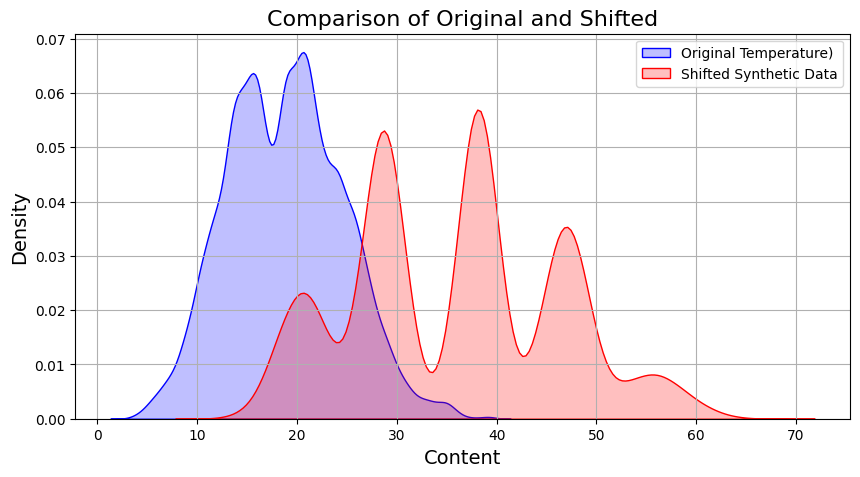

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))

# Distribución original
sns.kdeplot(
    data=X['Temperature'],
    label='Original Temperature)',
    fill=True,
    color='blue'
)

# Distribución sintética (shifted)
sns.kdeplot(
    data=X_synthetic['Temperature'],
    label='Shifted Synthetic Data',
    fill=True,
    color='red'
)

# Etiquetas y título
plt.title('Comparison of Original and Shifted', fontsize=16)
plt.xlabel('Content', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()